- https://nbviewer.jupyter.org/github/harnalashok/credit_risk/blob/main/start-here-a-gentle-introduction.ipynb
- https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://medium.com/analytics-vidhya/a-quick-guide-on-missing-data-imputation-techniques-in-python-2020-5410f3df1c1e
- https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features?scriptVersionId=0
- https://www.kaggle.com/robertknight/home-credit-default-risk-modelling

### Import Libraries

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as zf
from IPython.core.display import Image, display
import warnings
warnings.filterwarnings("ignore")

# import sklearn packages for modelling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

# import sklearn-classifiers
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import time

# Data Visualization set up
import matplotlib
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [213]:
train_set = pd.read_csv('02_dataset/train_set.csv', index_col = [0])
#columns_description = pd.read_csv(zip.open('HomeCredit_columns_description.csv'), index_col = 0, encoding = 'ISO-8859-1')

### 1. Data Transformation (Encoding)

One thing that jumps out by looking at the data is that some features here are objects or strings instead of numeric. Machine learning models require all input and output variables to be numeric. Unfortunately, a lot of ML models cannot deal with categorical variables (except for some such as LightGBM)[1]. Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model.

In order to encode the categorical variables, we can use two methods:
- Label Encoder - for categorical variables with 2 classes, converting the value to binary (0 or 1)
- OneHotEncoding - for categorical variables with multiple classes, one hot encoding transformed each class into a new column which is then a binary value.

#### 1.1. Label Encoding

In this technique, each label is assigned a unique integer based on alphabetical ordering. LabelEncoder encode labels with a value between 0 and n_classes-1 where n is the number of distinct labels [2].

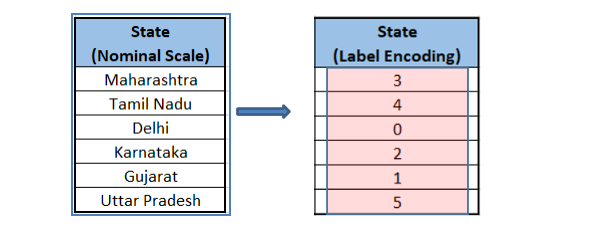

In [130]:
display(Image('01_pictures/label_encoding.png'))

In [214]:
## LabelEncoding for categorical variables with 2 classes
le = LabelEncoder()
for col in train_set:
    if train_set[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_set[col].unique())) <= 2:
            # Train on the training data
            le.fit_transform(train_set[col])
            print('%s was label encoded.' % col)
train_set = pd.get_dummies(train_set)

NAME_CONTRACT_TYPE was label encoded.
FLAG_OWN_CAR was label encoded.
FLAG_OWN_REALTY was label encoded.


#### 1.2. One-Hot Encoding

The solution to this problem is achieved by incorporating the concept of dummy columns. For each of the values of a certain category, a new column is introduced. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature [3]. 

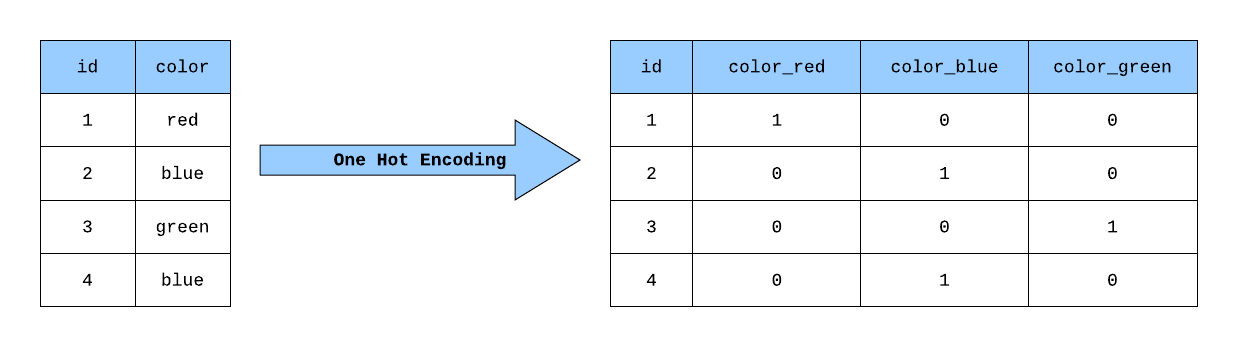

In [132]:
display(Image('01_pictures/one_hot_encoding.png'))

In [215]:
## OneHotEncoding of categorical variables
train_set = pd.get_dummies(train_set)
print('Training Features shape: ', train_set.shape)

Training Features shape:  (307511, 194)


### 2. Manual Feature Engineering

The goal of feature engineering is simply to make your data better suited to the problem at hand. One might perform feature engineering to [4]: 

- improve a model's predictive performance<br>
- reduce computational or data needs<br>
- improve interpretability of the results

For this dataset, the gorup created three additional variables, which in terms of credit-risk modelling make economically most sense:
- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months

In [216]:
# additional features for train-set
train_set['CREDIT_INCOME_PERCENT'] = train_set['AMT_CREDIT'] / train_set['AMT_INCOME_TOTAL']
train_set['ANNUITY_INCOME_PERCENT'] = train_set['AMT_ANNUITY'] / train_set['AMT_INCOME_TOTAL']
train_set['CREDIT_TERM'] = train_set['AMT_ANNUITY'] / train_set['AMT_CREDIT']

### 3. Correlation Analysis

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features. In this project, we are dropping all columns which have a correlation of greater or equal than 0.95 [5]. 

In [ ]:
correlated_features = set()
correlation_matrix = train_set.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
#These are the features that will be dropped.
train_set.drop(labels=correlated_features, axis=1, inplace=True)

### 4. Missing Value Handling & Standard-Scaling

#### 4.1. Median Imputation

In [219]:
def impute_data(df):
  
    """"
    OUTPUT:
    filled_numerical_df - dataframe with filled missing values with median-value (imputation)
    """
    
    # Numerical features
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O' ]
    
    # Fill missing values with median of column
    imputer = SimpleImputer(strategy = 'median')
    filled_numerical_df = imputer.fit_transform(df[numerical_features])
    filled_numerical_df = pd.DataFrame(data=filled_numerical_df, columns=df[numerical_features].columns.values)
    
    return filled_numerical_df

train_set = impute_data(train_set)

#### 4.2. Train-Test Split

In [220]:
#Split the clean dataset again
X = train_set.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train_set[['TARGET']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 2021)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (215257, 181)
Testing data shape:  (92254, 181)


#### 4.3. Standard-scaling (Min-Max)

In [221]:
# Save Feature names
features = list(X_train.columns)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Apply scaler on training/test-set
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (215257, 181)
Testing data shape:  (92254, 181)


In [222]:
X_train = pd.DataFrame(train, columns = features)
X_test = pd.DataFrame(test, columns = features)

### 5. Feature Importance

##### 5.1. PCA

PCA is a great tool to help discovering important relationships in the data and can also be used to create more informative features. The main idea of principal component analysis (PCA) is to reduce the dimensionality of a data set consisting of many variables correlated with each other, either heavily or lightly, while retaining the variation present in the dataset, up to the maximum extent. The same is done by transforming the variables to a new set of variables, which are known as the principal components (or simply, the PCs) and are orthogonal, ordered such that the retention of variation present in the original variables decreases as we move down in the order. So, in this way, the 1st principal component retains maximum variation that was present in the original components. The principal components are the eigenvectors of a covariance matrix, and hence they are orthogonal [6]. <br>
<br>
PCA also has several disadvantages [7]:
- \textbf{Model performance}: PCA can lead to a reduction in model performance on datasets with no or low feature correlation <br>
- \textbf{Outliers}: PCA is also affected by outliers, and normalization of the data needs to be an essential component of any workflow.<br>
- \textbf{Interpretability}: Each principal component is a combination of original features and does not allow for the individual feature importance to be recognized.

In [159]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

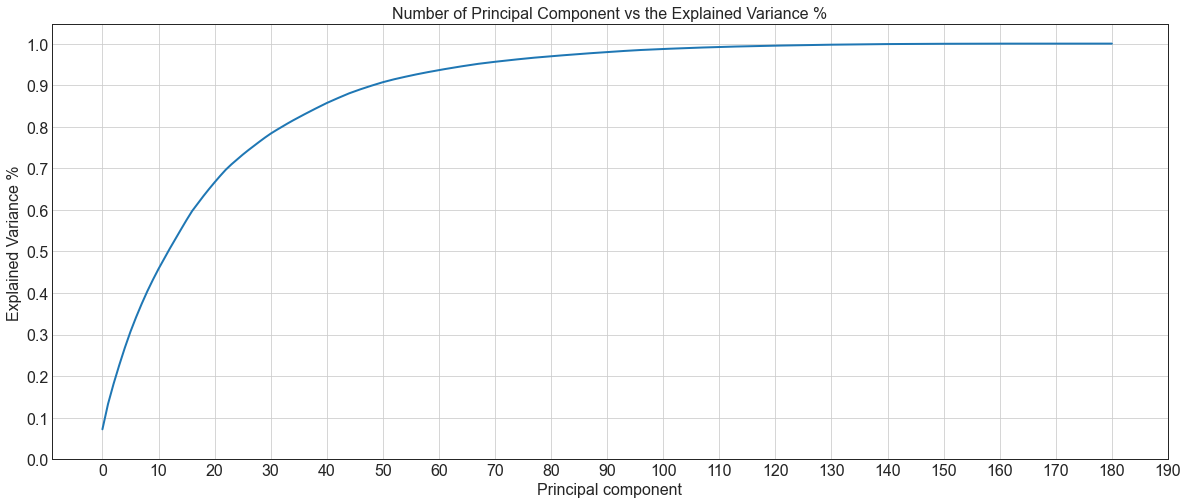

In [160]:
pca.n_components = len(X.columns)
pca_data = pca.fit_transform(X_train)
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained = np.cumsum(percentage_var_explained)  
plt.figure(1,figsize=(20,8))
plt.clf()  
y_range = np.arange(0.00,1.1,0.1)
x_range = np.arange(0,200,10)
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.title('Number of Principal Component vs the Explained Variance %')
plt.xlabel('Principal component') 
plt.ylabel('Explained Variance %') 
plt.yticks(y_range)
plt.xticks(x_range)
plt.grid()
plt.show()

Based on the Number of Component vs the explained variance ratio percentage, we can see that between 80 and 100 components covered more than 95% of the data. Therefore, we will use the number of component between 80 and 110 and c as range values to find the best estimator.

##### 5.2. Feature Importance

In [ ]:
# https://www.kaggle.com/sz8416/6-ways-for-feature-selection

In [13]:
X_train = pd.read_csv('02_dataset/X_train.csv', index_col = 0)
X_test = pd.read_csv('02_dataset/X_test.csv', index_col = 0)
y_train = pd.read_csv('02_dataset/y_train.csv', index_col = 0)
y_test = pd.read_csv('02_dataset/y_test.csv', index_col = 0)

In [2]:
target_train = y_train['TARGET']

Since we have more than 190 features, we need to reduce dimensions and select or extact key features from training datasets.

Method 1: ANOVA F-value from Univariate selection

In [5]:
f_class = SelectKBest(f_classif, k=120)
f_class.fit(X_train, np.ravel(target_train))
f_support = f_class.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()

Method 2. Recursive Feature Eliminatin from Wrapper method

In [6]:
rfe_selector = RFE(estimator=LogisticRegression(solver = 'lbfgs',max_iter = 4000), n_features_to_select = 120, step = 10, verbose = 5)
rfe_selector.fit(X_train, target_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()

Fitting estimator with 181 features.
Fitting estimator with 171 features.
Fitting estimator with 161 features.
Fitting estimator with 151 features.
Fitting estimator with 141 features.
Fitting estimator with 131 features.
Fitting estimator with 121 features.


Method 3. Lasso-Regession

In [7]:
embbed_lr = SelectFromModel(LogisticRegression(solver = 'liblinear',penalty = 'l1'),max_features = 120)
embbed_lr.fit(X_train, target_train)
emb_lr = embbed_lr.get_support()
emb_fea = X_train.loc[:,emb_lr].columns.tolist()

Method 4: Random Forest Classifiers

In [8]:
emb_rf_sel = SelectFromModel(RandomForestClassifier(n_estimators = 1200), max_features = 120)
emb_rf_sel.fit(X_train, target_train)
emb_rf_sup = emb_rf_sel.get_support()
emb_rf_fea = X_train.loc[:,emb_rf_sup].columns.tolist()

Display vote dataframe from above selection methods

In [14]:
vote_df = pd.DataFrame({"Feature":X_train.columns,
                        "Random Forest":emb_rf_sup,
                        "Lasso":emb_lr,
                        "RFE":rfe_support,
                        "ANOVA":f_support})

In [15]:
# select features where at least 3 classifiers agreed
vote_df['total'] = np.sum(vote_df, axis = 1)
vote_df = vote_df.sort_values(['total','Feature'],ascending = False)
feature_model_idx = vote_df[vote_df.total >= 3]['Feature']
selected_cols = feature_model_idx.reset_index()['Feature'].to_list()
X_train = X_train[feature_model_idx]
X_test = X_test[feature_model_idx]

In [18]:
# join test and train set together for further modelling
train_target_list = y_train.reset_index(drop = True)
test_target_list = y_test.reset_index(drop = True)
train_list = train_target_list['TARGET'].to_list()
test_list = test_target_list['TARGET'].to_list()

In [21]:
X_train['TARGET'] = train_list
X_test['TARGET'] = test_list

In [23]:
df_merge = pd.concat([X_train, X_test])

### 6. Save Final Model

In [25]:
df_merge.to_csv('home_credit_dataset_processed.csv')

### 7. References

[1] https://machinelearningmastery.com/one-hot-encoding-for-categoricaldata/#:~:text=Machine%20learning%20models%20require%20all,and%20a%20One%2DHot%20Encoding<br>
[2] https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b<br>
[3] https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/<br>
[4] https://www.kaggle.com/ryanholbrook/what-is-feature-engineering <br>
[5] https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf<br>
[6] https://www.dezyre.com/data-science-in-python-tutorial/principal-component-analysis-tutorial<br>
[7] https://medium.com/apprentice-journal/pca-application-in-machine-learning-4827c07a61db